In [12]:
import os  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
from keras.layers import concatenate,Dropout,Flatten
from tensorflow import optimizers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
num_classes        = 10
batch_size         = 64         # 64 or 32 or other
epochs             = 30
iterations         = 782       
DROPOUT=0.5 # keep 50%
CONCAT_AXIS=3
weight_decay=1e-4
DATA_FORMAT='channels_last' # Theano:'channels_first' Tensorflow:'channels_last'
log_filepath  = './alexnet'


model

In [13]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    if epoch < 200:
        return 0.001
    return 0.0001

# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)
x_train, x_test = color_preprocessing(x_train, x_test)


In [14]:
def alexnet(img_input,classes=10):
    x = Conv2D(96,(11,11),strides=(4,4),padding='same',
               activation='relu',kernel_initializer='uniform')(img_input)# valid
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    x = Conv2D(256,(5,5),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    
    x = Conv2D(384,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x) 
    
    x = Conv2D(384,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x) 
    
    x = Conv2D(256,(3,3),strides=(1,1),padding='same',
               activation='relu',kernel_initializer='uniform')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same',data_format=DATA_FORMAT)(x)
    x = Flatten()(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(classes, activation='softmax')(x)
    return out


In [10]:
img_input=Input(shape=(32,32,3))
output = alexnet(img_input)
model=Model(img_input,output)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 96)          34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 384)         132748

the structure of alexnet
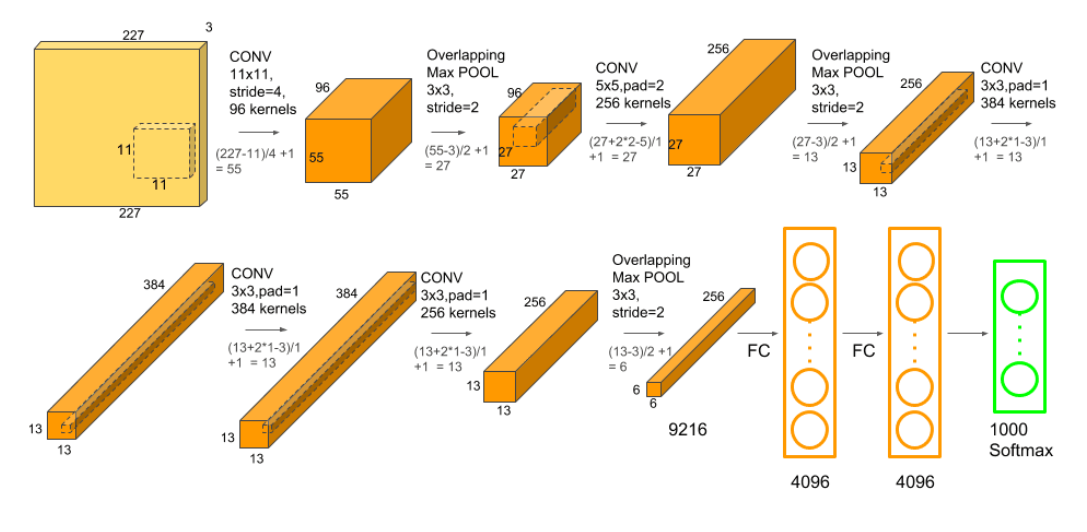

In [ ]:
# set optimizer
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

# set callback
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

# set data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
model.save('alexnet.h5')